# Photometric monitoring

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.coordinates import SkyCoord, EarthLocation
from astropy import units as u
from astropy.time import Time

In [3]:
import glob as glob
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns

import corner
import json
import pathlib
import pickle
import utils
import warnings
import sys

from astropy import constants as const
from astropy import units as uni
from astropy.io import ascii, fits
from astropy.time import Time
from mpl_toolkits.axes_grid1 import ImageGrid

# Default figure dimensions
FIG_WIDE = (11, 5)
FIG_LARGE = (8, 11)

# Figure style
sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
params = utils.plot_params()
plt.rcParams.update(params)

## [Dowload data](https://www.dropbox.com/sh/74sihxztgd82jjz/AADgB_f5RYc3De3IEioUGAfha?dl=1)

Unzip this into a folder named `data` in the same level as this notebook

## Load

In [11]:
dirpath = "../data/photometric"

mid_transit_times = {
    "Transit 1": "2013-12-19 12:00:00",
    "Transit 2": "2015-09-27 12:00:00",
    "Transit 3": "2016-12-11 12:00:00",
}

# Load processed data
df_stell_data = pd.read_csv(
    f"{dirpath}/AP37847073.csv",
#     names=["t_HJD", "t_UT", "f"],
#     parse_dates=[1],
#     infer_datetime_format=True,
)

# Load model data
# df_stell_model = pd.read_csv(
#     f"{dirpath}/HATP23_GP_model_Prot7_v3.csv", names=["t_HJD", "f", "f_err"]
# )

df_stell_data#.sort_values("hjd", inplace=True)
df_stell_data

,hjd,camera,filter,mag,mag err,flux (mJy),flux err
0,2.458364e+06,bd,V,11.748,0.02,76.097,1.400
1,2.458342e+06,bh,V,11.744,0.02,76.943,1.416
2,2.458087e+06,bh,V,11.735,0.02,77.610,1.428
3,2.458033e+06,bd,V,11.739,0.02,76.732,1.412
4,2.458016e+06,bh,V,11.745,0.02,76.872,1.414
...,...,...,...,...,...,...,...
272,2.457577e+06,bh,V,11.735,0.02,77.592,1.428
273,2.458002e+06,bd,V,11.741,0.02,76.601,1.409
274,2.457414e+06,bh,V,11.730,0.02,77.952,1.434
275,2.457396e+06,bd,V,11.738,0.02,76.861,1.414


In [25]:
coords_W50 = "1:12:43.2 +31:12:43"
def func_bd(x):
    x["bjd"] = helio_to_bary(coords_W50, x["hjd"], "Haleakala").value
    return x

def func_bh(x):
    x["bjd"] = helio_to_bary(coords_W50, x["hjd"], "CTIO").value
    return x

gdf = df_stell_data.groupby("camera")

df_bd = gdf.get_group("bd").apply(func_bd, axis=1)
df_bh = gdf.get_group("bh").apply(func_bh, axis=1)

In [38]:
pd.concat([df_bd, df_bh]).to_csv("../data/photometric/AP37847073_BJD.csv", index=False)

In [ ]:
helio_to_bary

In [2]:
# https://gist.github.com/StuartLittlefair/4ab7bb8cf21862e250be8cb25f72bb7a
def helio_to_bary(coords, hjd, obs_name):
    helio = Time(hjd, scale="utc", format="jd")
    obs = EarthLocation.of_site(obs_name)
    star = SkyCoord(coords, unit=(u.hour, u.deg)) 
    ltt = helio.light_travel_time(star, "heliocentric", location=obs)
    guess = helio - ltt
    
    # If we assume guess is correct - how far is heliocentric time away
    # from true value?
    delta = (
    guess + guess.light_travel_time(star, "heliocentric", obs)
    ).jd - helio.jd
    
    # Apply this correction
    guess -= delta * u.d
    ltt = guess.light_travel_time(star, 'barycentric', obs)
    
    return guess.tdb + ltt

In [9]:
# From https://gist.github.com/StuartLittlefair/4ab7bb8cf21862e250be8cb25f72bb7a
def helio_to_bary(coords, hjd, obs_name):
    helio = Time(hjd, scale='utc', format='jd')
    obs = EarthLocation.of_site(obs_name)
    star = SkyCoord(coords, unit=(u.hour, u.deg)) 
    ltt = helio.light_travel_time(star, 'heliocentric', location=obs)
    guess = helio - ltt
    # if we assume guess is correct - how far is heliocentric time away from true value?
    delta = (guess + guess.light_travel_time(star, 'heliocentric', obs)).jd  - helio.jd
    # apply this correction
    guess -= delta * u.d

    ltt = guess.light_travel_time(star, 'barycentric', obs)
    return guess.tdb + ltt

## Plot

In [42]:
df_stell_data["hjd"][10]

2457681.00027

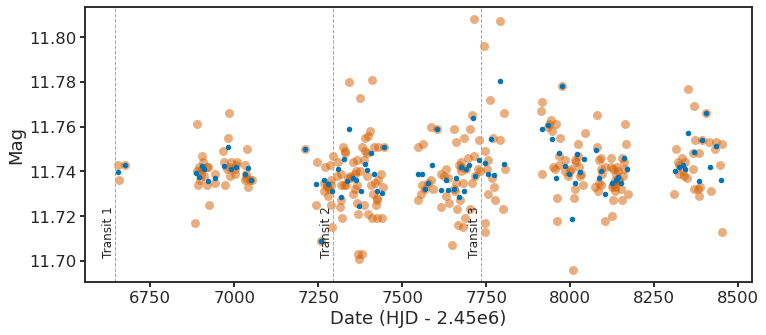

In [11]:
t, f = df_stell_data["hjd"].to_numpy() - 2.45e6, df_stell_data["mag"].to_numpy()
ferr = df_stell_data["mag err"].to_numpy() * np.ones_like(f)
t_binned, f_binned, f_err_binned = BinnedLC(
    t, f, ferr, diff_lim=7 #diff_lim=np.mean(np.diff(t_binned))
)

fig, ax = plt.subplots(figsize=FIG_WIDE)

ax.plot(t, f, "ro", alpha=0.5, mew=0)
# ax.plot(df_stell_model["t_HJD"], df_stell_model["f"], color="grey")
# f_d = df_stell_model["f"] - df_stell_model["f_err"]
# f_u = df_stell_model["f"] + df_stell_model["f_err"]
# ax.fill_between(df_stell_model["t_HJD"], f_d, f_u, alpha=0.3, lw=0, color="grey")

p_kwargs = {"ls": "--", "c": "darkgrey", "lw": 1.0}
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)

for transit_name, t0 in mid_transit_times.items():
    t_mid = Time(t0).jd - 2.45e6
    ax.axvline(t_mid, **p_kwargs)
    ax.annotate(
        transit_name,
        xy=(t_mid, 0.1),
        xycoords=trans,
        ha="right",
        rotation=90.0,
        fontsize=12,
    )
    
ax.plot(t_binned, f_binned, "b.")

# Save
#ax.set_ylim(0.88, 0.98)
ax.set_xlabel("Date (HJD - 2.45e6)")
ax.set_ylabel("Mag")
fig.tight_layout()
fig.set_size_inches(FIG_WIDE)
#utils.savefig("../paper/figures/photometric_act/phot_mon_full.pdf")

In [13]:
len(t_binned)

97

In [ ]:
plt.plot()

In [4]:
%matplotlib qt5

In [30]:
def weighted_avg_and_std(values, weights):
    """ Return the weighted average and standard deviation. values, weights -- Numpy ndarrays with the same shape."""
    average = np.average(values, weights=weights) #weights = 1./err_bar^2. Where err_bar=std & err_bar^2 = variance
    variance = np.average((values-average)**2, weights=weights) # Fast and numerically precise
    return average, np.sqrt(variance)

In [10]:
x = np.random.rand(10)
y = np.random.rand(10)
y_const = 0.5*np.ones_like(x)

In [18]:
x, y

(array([0.63813037, 0.93437013, 0.34960093, 0.21659307, 0.86643459,
        0.67943137, 0.56334442, 0.76031477, 0.2392301 , 0.00885744]),
 array([0.15513163, 0.68357178, 0.2272109 , 0.13385555, 0.24589623,
        0.21925811, 0.90703954, 0.00996151, 0.08618509, 0.54013659]))

In [28]:
weighted_avg_and_std(x, 1/y**2)

(0.7491412761337924, 0.3675820054373738)

In [24]:
def weighted_avg2(values, errors):
    avg = np.sum(values/(errors**2)) / np.sum(1/(errors**2))
    avg_unc = np.sqrt(1/(np.sum(errors**-2)))
    return(avg, avg_unc)

In [22]:
weighted_avg2(x, y)

(0.7491412761337924, 0.009818600762283749)

In [10]:
triangular_number = lambda n: int(n)*(int(n)+1)//2 #this is addition factorial. i.e X+(X-1)+(X-2)+(X-3)...

def weighted_avg_and_std(values, weights):
    """ Return the weighted average and standard deviation. values, weights -- Numpy ndarrays with the same shape."""
    average = np.average(values, weights=weights) #weights = 1./err_bar^2. Where err_bar=std & err_bar^2 = variance
    variance = np.average((values-average)**2, weights=weights) # Fast and numerically precise
    return average, np.sqrt(variance)

# to code that averages the datapoints that are close in time
def BinnedLC(time, flux, flx_err, diff_lim=.1): # diff_lim = max difference in time [days]. 0.1 = 2.4hrs
    #To block togther all datapoints that have similar times stamps
    DiffGroupTotal = [] #This will be a list of list, where each list holds the indeces that should be combined 
    DiffGroup_i = [] #To keep track of elements that should be combined
    Start_i, end_i = 0, 1 #The 1st index of DiffGroup_i. end_i is initalized to Start_i+1
    for d in range(0,len(time)-1):
        if time[d+1]-time[Start_i]<diff_lim: #If the 1st element (Start_i) and the last element searched (end_i) have a time difference less than 'diff_lim,' add those indeces
            if len(DiffGroup_i) == 0: #Starting new group cointaining small time differences amongst them
                DiffGroup_i.append(Start_i) #add start to the list of close times
                DiffGroup_i.append(d+1)
                Start_i = d #To keep track of where DiffGroup_i started
            else: #if DiffGroup_i already initialized, add next element to our list
                DiffGroup_i.append(d+1)
        else:
            if len(DiffGroup_i) > 1: # if the previous step was the last step in the grouped times, append the DiffGroup_i to DiffGroupTotal
                DiffGroupTotal.append(DiffGroup_i)
            if time[d+1]-time[d]> diff_lim and d not in DiffGroup_i: #only add individual element if not going to go
                DiffGroupTotal.append([d]) #in the next list
            Start_i= d+1 #reset Start_i
            DiffGroup_i = [] #rest the group list
    if len(DiffGroup_i) > 1: # For the last element
        DiffGroupTotal.append(DiffGroup_i)
    else:
        DiffGroupTotal.append([d+1])
    
    #Extra checks to make sure all the indecies are accounted for in the right sub-lists:
    TotalSum = 0 #to check if adds
    for i in range(len(DiffGroupTotal)): #To scan each sublist
        sublist = DiffGroupTotal[i]
        FirstTime, LastTime = time[sublist[0]], time[sublist[-1]]
        if LastTime-FirstTime > diff_lim: #To make sure the differences of the indeces I marked in each subdirectory are indeed within the approporate limit
            sys.exit("In sublist "+str(i)+", the 1st and last times are "+str(FirstTime)+","+str(LastTime)+". Their difference is greater than diff_lim!!!!")
        TotalSum += np.sum(sublist)
    Triangle = triangular_number(len(time)-1) #triangle number of len(time)-1, to makes sure every index is accounted for
    if TotalSum != Triangle:
        print ("Sum of all indeces is "+str(TotalSum)+". However, the triangle number of the inputed time array length is "+str(Triangle)+".") 
        print ("DiffGroupTotal", DiffGroupTotal)
        sys.exit()
        
    #To weight average all blocked data
    new_time, new_flux, new_FlxErr = [], [], []
    for g in DiffGroupTotal:
        if len(g) == 1:
            new_time.append(time[g][0]),  new_flux.append(flux[g][0]), new_FlxErr.append(flx_err[g][0])
        else:
            Flux, STD = weighted_avg_and_std(flux[g], 1./(flx_err[g]**2))
            new_time.append(np.mean(time[g])),  new_flux.append(Flux), new_FlxErr.append(STD)
    
    return np.array(new_time, dtype="object"), np.array(new_flux, dtype="object"), np.array(new_FlxErr, dtype="object") #need the "object" because each array is of different size